In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import random
mpl.rcParams['font.sans-serif'] = ['KaiTi']
mpl.rcParams['font.serif'] = ['KaiTi']
mpl.rcParams['axes.unicode_minus'] = False
from tqdm import tqdm

In [2]:
data_root = './raw_data/Australia_power.xlsx'

In [3]:
df = pd.read_excel(data_root)

In [6]:
df.drop(columns=['电价'],inplace=True)

In [8]:
df.columns = ['date','hour','max_T','min_T','avg_T','D','Power']

In [11]:
df['date'] = pd.to_datetime(df['date'])

In [13]:
df = df.set_index('date')

日负荷曲线

In [22]:
day_power = df.resample('D').sum()['Power']

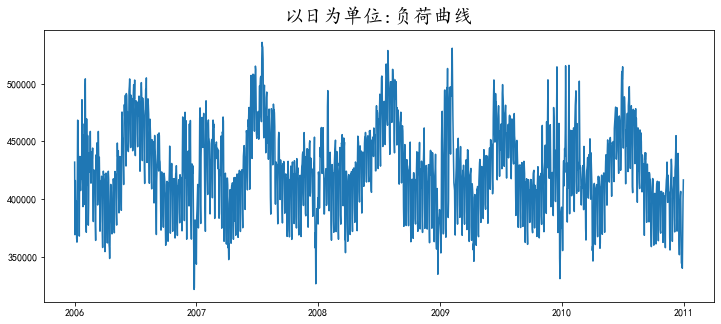

In [47]:
plt.figure(figsize=(12,5))
plt.title('以日为单位:负荷曲线',fontsize=20)
plt.plot(day_power[:-1])
plt.show()

月负荷曲线

In [28]:
month_power = df.resample('M').sum()['Power']

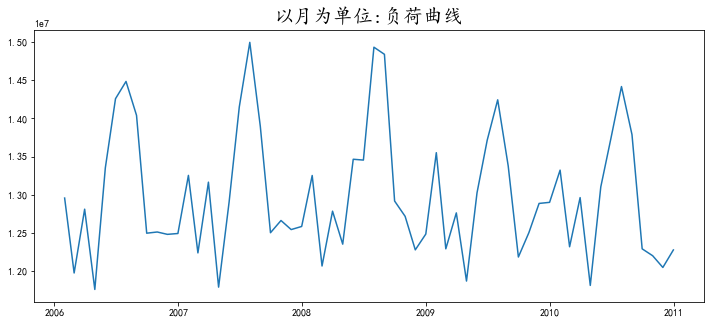

In [46]:
plt.figure(figsize=(12,5))
plt.title('以月为单位:负荷曲线',fontsize=20)
plt.plot(month_power[:-1])
plt.show()

季度负荷曲线

In [43]:
season_power = df.resample('Q').sum()['Power']

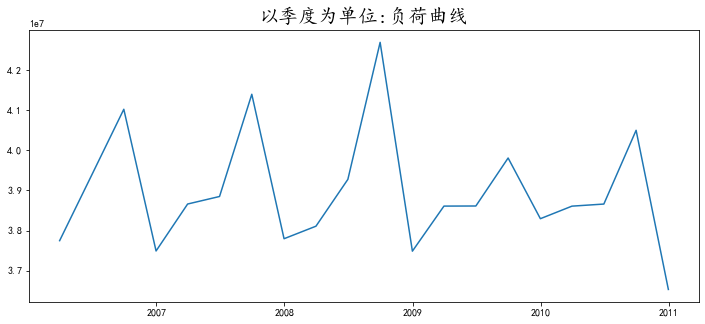

In [52]:
plt.figure(figsize=(12,5))
plt.title('以季度为单位:负荷曲线',fontsize=20)
plt.plot(season_power[:-1])
plt.show()

年度负荷曲线

In [60]:
year_power = df.resample('A').sum()['Power']

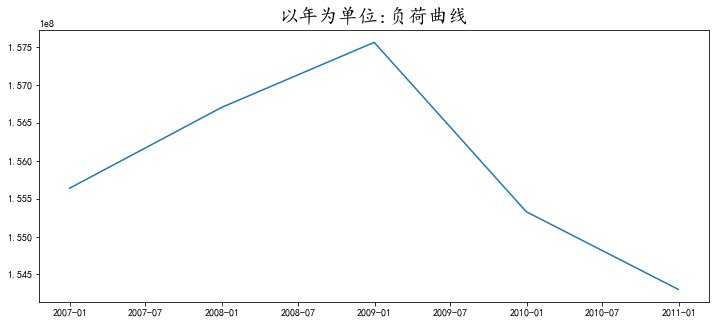

In [66]:
plt.figure(figsize=(12,5))
plt.title('以年为单位:负荷曲线',fontsize=20)
plt.plot(year_power[:-1])
plt.show()

2006-2009年(4年)作为训练集
 
2010年(1年)作为测试集

In [74]:
train_data = df['2006-01-02':'2009-12-31']

In [77]:
test_data = df['2010-01-01':'2010-12-31']

添加特征,为聚类以及决策树分类做准备

In [116]:
train_day_info = train_data.groupby('date')[['avg_T','D']].mean()

In [118]:
train_day_info.columns = ['avg_T','avg_D']

In [120]:
train_day_info['max_T'] = None
train_day_info['min_T'] = None
train_day_info['max_D'] = None
train_day_info['min_D'] = None

In [127]:
for i in range(48):
    col = str(i/2)+"h_power"
    train_day_info[col] = None

In [20]:
hour_list = []
for i in range(48):
    col = str(i/2)+"h_power"
    hour_list.append(col)

In [161]:
for name,group in train_data.groupby(['date']):
    train_day_info.loc[name,hour_list] = group['Power'].values
    train_day_info.loc[name,'max_T'] = group['max_T'].max()
    train_day_info.loc[name,'min_T'] = group['min_T'].min()
    train_day_info.loc[name,'max_D'] = group['D'].max()
    train_day_info.loc[name,'min_D'] = group['D'].min()

In [176]:
train_day_info['date'] = train_day_info.index

In [217]:
train_day_info['month'] = train_day_info['date'].map(lambda x:x.month)
train_day_info['day'] = train_day_info['date'].map(lambda x:x.day)
train_day_info['weekday'] = train_day_info['date'].map(lambda x:x.weekday())

In [219]:
train_day_info.drop(columns=['date'],inplace=True)

In [240]:
def Is_holiday(x):
    if (x==0 or x==6):return 1
    else:return 0

In [241]:
train_day_info['is_holiday'] = train_day_info['weekday'].apply(Is_holiday)

除了双休日外,还有法定节假日

1月1日
1月27日
4月25日
12月25日
12月26日

In [260]:
train_day_info.loc[(train_day_info['month']==1)&(train_day_info['day']==1),'is_holiday'] = 1
train_day_info.loc[(train_day_info['month']==1)&(train_day_info['day']==27),'is_holiday'] = 1
train_day_info.loc[(train_day_info['month']==4)&(train_day_info['day']==25),'is_holiday'] = 1
train_day_info.loc[(train_day_info['month']==12)&(train_day_info['day']==25),'is_holiday'] = 1
train_day_info.loc[(train_day_info['month']==12)&(train_day_info['day']==26),'is_holiday'] = 1

保存数据

In [271]:
train_day_info.to_csv('./raw_data/train_day_info.csv')
train_data.to_csv('./raw_data/train_data.csv')
test_data.to_csv('./raw_data/test_data.csv')

读取数据

In [2]:
train_day_info = pd.read_csv('./raw_data/train_day_info.csv')

In [5]:
train_day_info['date'] = pd.to_datetime(train_day_info['date'])

In [9]:
train_day_info = train_day_info.set_index('date')

In [11]:
train_data = pd.read_csv('./raw_data/train_data.csv')
test_data = pd.read_csv('./raw_data/test_data.csv')

In [13]:
train_data['date'] = pd.to_datetime(train_data['date'])
train_data = train_data.set_index('date')

In [16]:
test_data['date'] = pd.to_datetime(test_data['date'])
test_data = test_data.set_index('date')

这里的聚类思路：

1.对曲线特征聚类，而不是对负荷量聚类;因此,根据各点间斜率聚类

2.这里采用k-medoids聚类,因为k-means聚类的前提是数据集呈高斯分布，对特殊数据过于敏感

3.度量方式采用欧式距离

差分(斜率特征)

In [13]:
diff_hour_list = []
for i in range(1,48):
    col = 'diff_'+str(i/2)+"h_power"
    diff_hour_list.append(col)

In [37]:
for col in diff_hour_list:
    train_day_info[col] = None

In [76]:
for date in train_day_info.index:
    train_day_info.loc[date,diff_hour_list] = train_day_info.loc[date,hour_list].diff().values[1:]

定义基于余弦相似度的k-medoids算法

这里，参考k-means++初始化聚类中心的方法,对k-medoids算法的初始化进行修改

In [208]:
class KMediod():
    def __init__(self,data,k_num_center):
        self.k_num_center = k_num_center
        self.data = data
    
    def ou_distance(self, x, y):
        return np.sqrt(sum(np.square(x - y)))
#         num = x.dot(y.T)
#         denom = np.linalg.norm(x) * np.linalg.norm(y)
#         return num / denom
    
    def init_centroids(self):
        init_centroids_index = np.random.randint(0,len(self.data))
        centroid = self.data[init_centroids_index,:]   
        centroids = [centroid]
        
        for i in range(1,self.k_num_center):
            
            sample_distance = []
            sum_dist = 0
            cur_sum = 0
            
            for sample in self.data:
                distances = [self.ou_distance(sample, centroid) for centroid in centroids]
                nearest_dist = np.array(distances).min()
                sample_distance.append(nearest_dist)
                sum_dist += nearest_dist
                
            distance_thresh = sum_dist * np.random.random()
            
            for i,sample in enumerate(self.data):
                cur_sum += sample_distance[i]
                if cur_sum > distance_thresh:
                    centroids.append(sample)
                    break
        
        return centroids
 
    def run_k_center(self,):
        centroids = self.init_centroids()
        sample_target = []
        if_stop = False
        while(not if_stop):
            if_stop = True
            classify_points = [[centroid] for centroid in centroids]
            sample_target = []

            for sample in self.data:
                distances = [self.ou_distance(sample, centroid) for centroid in centroids]
                cur_level = np.argmin(distances)
                sample_target.append(cur_level)
                classify_points[cur_level].append(sample)
                
            for i in range(self.k_num_center):  
                distances = [self.ou_distance(point_1, centroids[i]) for point_1 in classify_points[i]]
                now_distances = sum(distances)   
                for point in classify_points[i]:
                    distances = [self.ou_distance(point_1, point) for point_1 in classify_points[i]]
                    new_distance = sum(distances)
                    
                    if new_distance < now_distances:
                        now_distances = new_distance
                        centroids[i] = point   
                        if_stop = False
        return sample_target,centroids
 
    def run(self):
        sample_target,centroids = self.run_k_center()
        return sample_target,centroids

测试该算法

In [139]:
from sklearn.datasets import make_blobs

In [209]:
data, target = make_blobs(n_samples=1000, n_features=2, centers=4)

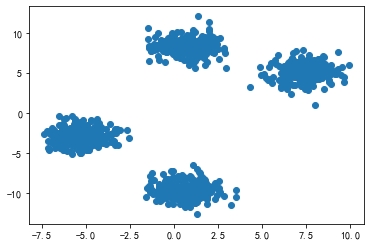

In [210]:
plt.scatter(data[:, 0],data[:, 1])

In [218]:
k_mediod = KMediod(data,4)

In [219]:
sample_target_t,centroids_t = k_mediod.run()

In [220]:
centroids_t = np.array(centroids_t)

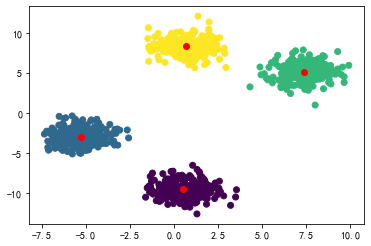

In [221]:
plt.scatter(data[:, 0],data[:, 1],c=sample_target_t)
plt.scatter(centroids_t[:,0],centroids_t[:,1],c='r')

测试通过，用于聚类

In [150]:
train_day_info.to_csv('./raw_data/train_day_info.csv')
train_data.to_csv('./raw_data/train_data.csv')
test_data.to_csv('./raw_data/test_data.csv')

In [2]:
train_day_info = pd.read_csv('./raw_data/train_day_info.csv')
train_data = pd.read_csv('./raw_data/train_data.csv')
test_data = pd.read_csv('./raw_data/test_data.csv')

In [8]:
train_day_info['date'] = pd.to_datetime(train_day_info['date'])
train_day_info = train_day_info.set_index('date')

In [9]:
train_data['date'] = pd.to_datetime(train_data['date'])
train_data = train_data.set_index('date')
test_data['date'] = pd.to_datetime(test_data['date'])
test_data = test_data.set_index('date')

为了评价最优聚类数，这里采用DBI指数

原DBI公式内各点间距离为欧式距离，这里改用余弦相似度

In [222]:
def ou_distance(x, y):
    return np.sqrt(sum(np.square(x - y)))
#     num = x.dot(y.T)
#     denom = np.linalg.norm(x) * np.linalg.norm(y)
#     return num / denom

In [223]:
def DaviesBouldin(X, labels):
    n_cluster = len(set(labels))
    cluster_keys = {v:i for i,v in enumerate(set(labels))}
    t_labels = np.array([cluster_keys[labels[i]] for i in range(len(labels))])
    
    cluster_k = [X[t_labels == k] for k in range(n_cluster)]
    centroids = [np.mean(k, axis = 0) for k in cluster_k]

    S = [np.mean([ou_distance(p, centroids[i]) for p in k]) for i, k in enumerate(cluster_k)]
    Ri = []

    for i in range(n_cluster):
        Rij = []
        for j in range(n_cluster):
            if j != i:
                r = (S[i] + S[j]) / ou_distance(centroids[i], centroids[j])
                Rij.append(r)
        Ri.append(max(Rij)) 

    dbi = np.mean(Ri)

    return dbi

设典型负荷曲线为4

In [23]:
k_mediod = KMediod(train_day_info[diff_hour_list].values,4)

In [24]:
sample_target,centroids = k_mediod.run()

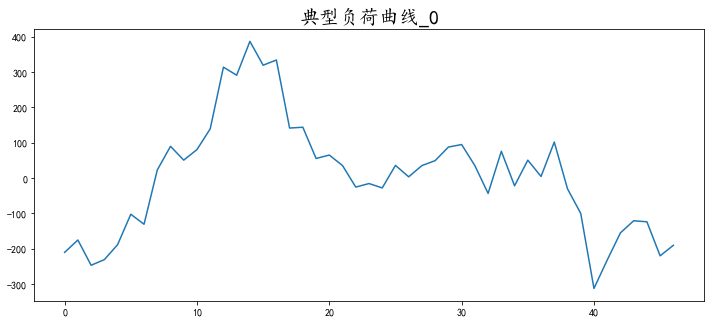

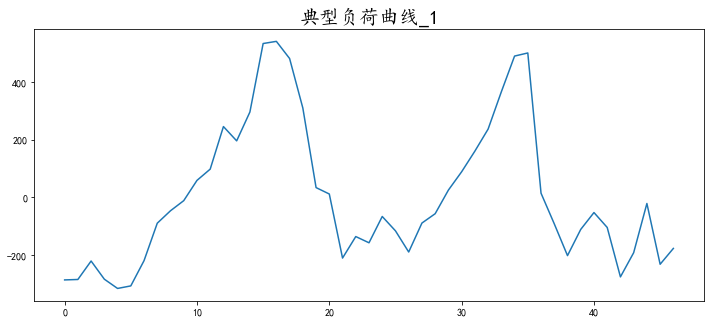

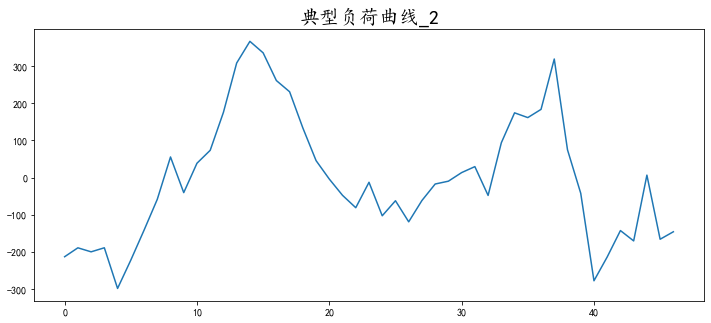

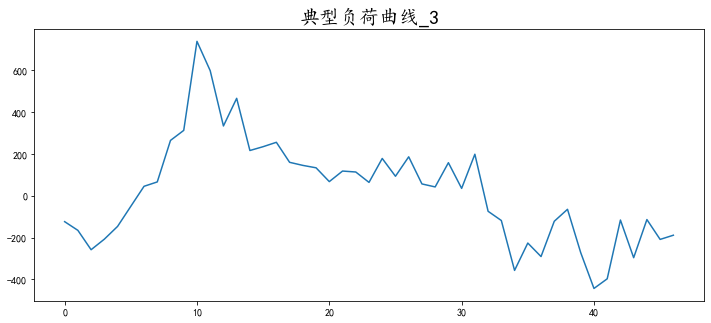

In [32]:
for i in range(4):
    plt.figure(figsize=(12,5))
    plt.title('典型负荷曲线_'+str(i),fontsize=20)
    plt.plot(centroids[i])
    plt.show()

计算DBI

In [131]:
DaviesBouldin(train_day_info[diff_hour_list].values,sample_target)

2.753487322262404

通过DBI,在2-7中选择最合适的聚类数目

In [224]:
dbi_list = []
centroid_list = []
sample_list = []

In [225]:
for i in tqdm(range(2,8)):
    k_mediod = KMediod(train_day_info[diff_hour_list].values,i)
    sample_target,centroids = k_mediod.run()
    dbi = DaviesBouldin(train_day_info[diff_hour_list].values,sample_target)
    
    dbi_list.append(dbi)
    centroid_list.append(centroids)
    sample_list.append(sample_target)

100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [02:48<00:00, 28.16s/it]


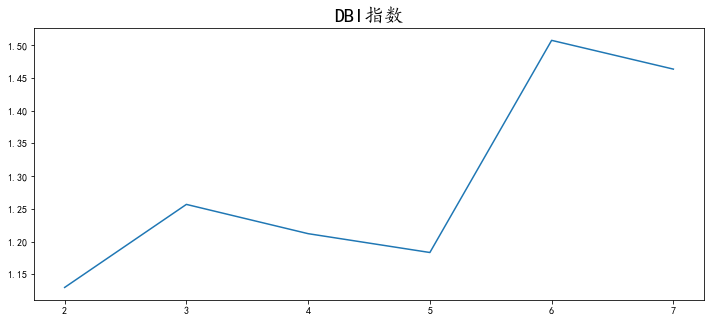

In [226]:
plt.figure(figsize=(12,5))
plt.title('DBI指数',fontsize=20)
plt.plot(range(2,8),dbi_list)
plt.show()

选择2

In [227]:
centroids = centroid_list[0]

In [232]:
sample_target = np.array(sample_list[0])

In [234]:
for i in range(2):
    print("第"+str(i)+"种曲线个数：")
    print(len(sample_target[sample_target==i]))

第0种曲线个数：
753
第1种曲线个数：
707


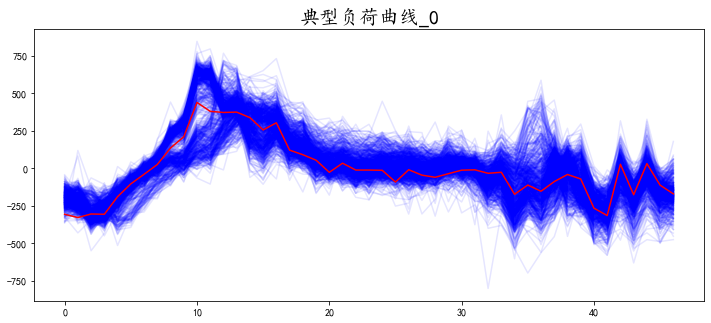

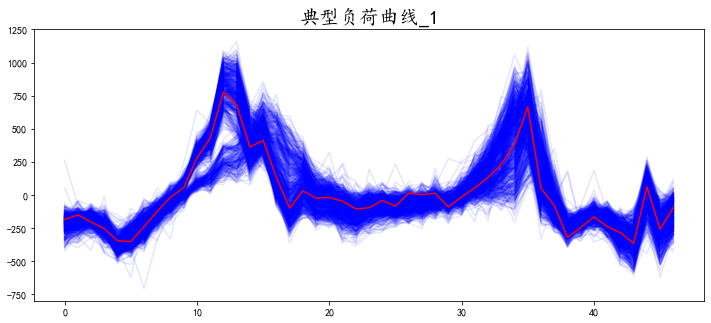

In [256]:
for i in range(2):
    plt.figure(figsize=(12,5))
    plt.title('典型负荷曲线_'+str(i),fontsize=20)
    for date in train_day_info[sample_target==i].index:
        day_data = train_day_info[sample_target==i].loc[date,diff_hour_list].values
        plt.plot(day_data,c='b',alpha=0.1)
    plt.plot(centroids[i],c='r')
    plt.show()

采用sklearn中的k-means算法聚类

In [257]:
from sklearn.cluster import KMeans

In [273]:
k_dbi_list = []
k_centroid_list = []
k_sample_list = []

In [274]:
for i in tqdm(range(2,8)):
    k_cluster = KMeans(n_clusters=i).fit(train_day_info[diff_hour_list].values)
    k_centroid=k_cluster.cluster_centers_
    k_sample_target = k_cluster.predict(train_day_info[diff_hour_list].values)
    k_dbi = DaviesBouldin(train_day_info[diff_hour_list].values,k_sample_target)
    
    k_dbi_list.append(k_dbi)
    k_centroid_list.append(k_centroid)
    k_sample_list.append(k_sample_target)

100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  7.92it/s]


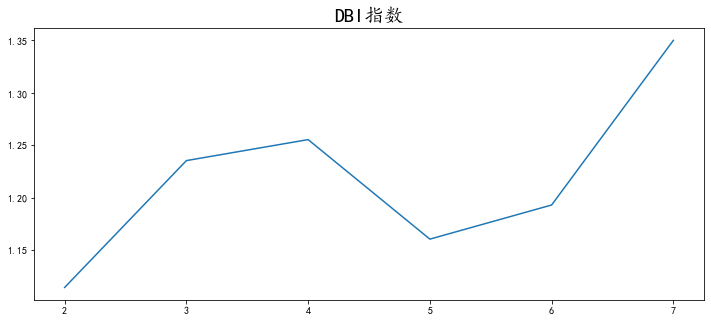

In [275]:
plt.figure(figsize=(12,5))
plt.title('DBI指数',fontsize=20)
plt.plot(range(2,8),k_dbi_list)
plt.show()

感觉这里k-means算法聚类后的dbi指数会更低?

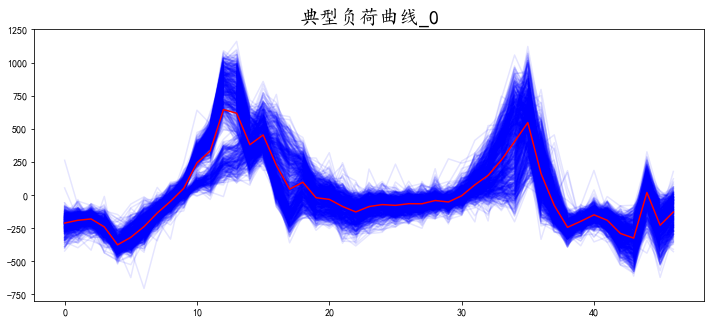

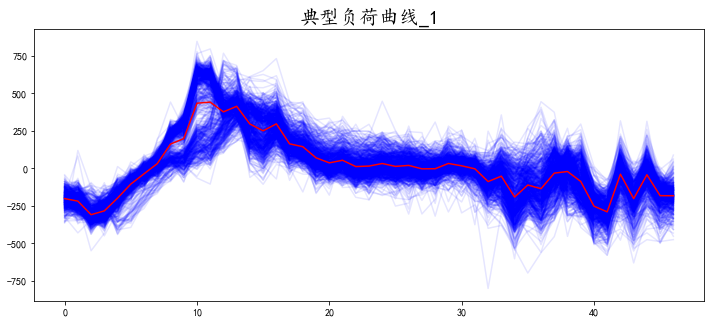

In [266]:
for i in range(2):
    plt.figure(figsize=(12,5))
    plt.title('典型负荷曲线_'+str(i),fontsize=20)
    for date in train_day_info[k_sample_target==i].index:
        day_data = train_day_info[k_sample_target==i].loc[date,diff_hour_list].values
        plt.plot(day_data,c='b',alpha=0.1)
    plt.plot(k_centroid[i],c='r')
    plt.show()

因此决定分类为两个簇

In [279]:
k_sample_target = k_sample_list[0]

In [336]:
classify_features = ['avg_T','avg_D','max_T','min_T','max_D','min_D', 'month','day','weekday','is_holiday']

In [295]:
train_day_info['class'] = None
train_day_info['class'] = k_sample_target

In [334]:
from sklearn import tree
import lightgbm as lgb
import graphviz
import pydotplus
from IPython.display import Image  

In [335]:
lgb_clf = lgb.LGBMClassifier()

In [337]:
lgb_clf.fit(train_day_info[classify_features],train_day_info['class'])

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [339]:
importance_features = pd.DataFrame({
        'column':classify_features,
        'importance':lgb_clf.feature_importances_,
}).sort_values(by='importance',ascending=False)

通过gini值直接分析特征重要性

In [340]:
importance_features

,column,importance
6,month,603
2,max_T,508
0,avg_T,432
7,day,427
5,min_D,257
1,avg_D,241
3,min_T,224
4,max_D,166
8,weekday,88
9,is_holiday,25


尝试计算SHAP值

In [342]:
import shap
shap.initjs()

In [343]:
explainer = shap.TreeExplainer(lgb_clf)
shap_values = explainer.shap_values(train_day_info[classify_features])

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


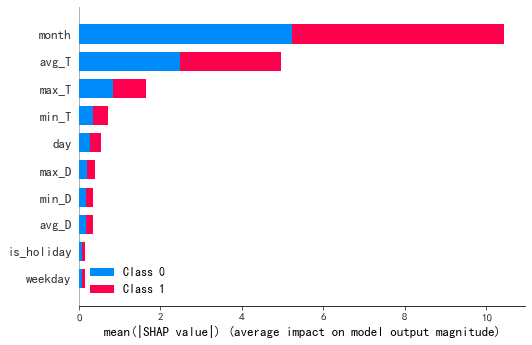

In [344]:
shap.summary_plot(shap_values,train_day_info[classify_features],plot_type="bar")

根据shap值,仅选出前4个特征

In [348]:
classify_features = ['month','max_T','min_T','avg_T']

验证该算法分类的准确性

In [352]:
classify_data = train_day_info[['month','max_T','min_T','avg_T','class']].copy()

In [354]:
from sklearn.model_selection import train_test_split

随机抽取百分之二十作为测试集

In [356]:
X_train, X_test, y_train, y_test = train_test_split(classify_data[classify_features],classify_data['class'], test_size=0.2)

In [357]:
lgb_clf = lgb.LGBMClassifier()

In [363]:
lgb_clf.fit(X_train,y_train)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [364]:
lgb_clf.score(X_test,y_test)

0.952054794520548

分类正确率在95%以上,可行

In [370]:
lgb_clf = lgb.LGBMClassifier()

In [371]:
lgb_clf.fit(train_day_info[classify_features],train_day_info['class'])

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

分类规则可视化

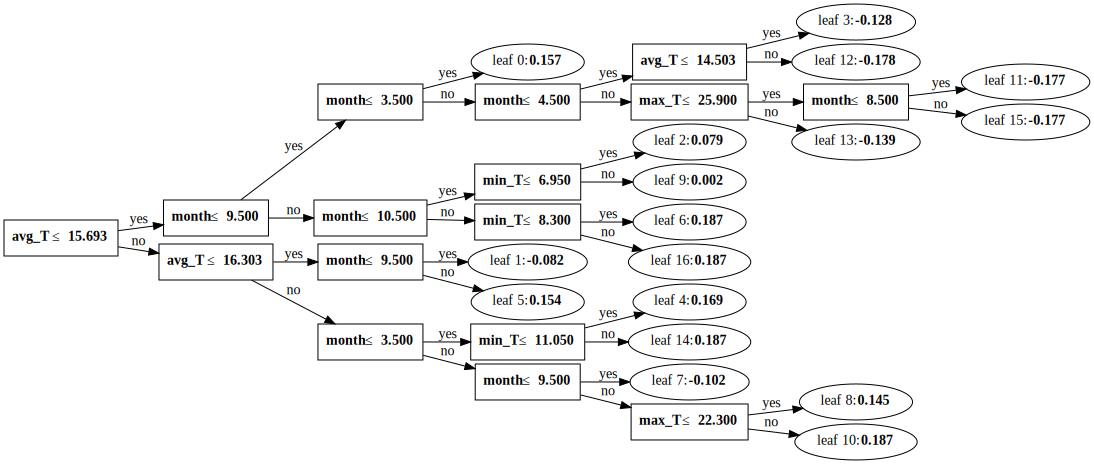

In [373]:
lgb.create_tree_digraph(lgb_clf,tree_index=1)

保存该分类树

In [424]:
import joblib

In [426]:
joblib.dump(lgb_clf,'./raw_data/lgb_clf.pkl')

['./raw_data/lgb_clf.pkl']

将分类结果加入训练数据中

In [379]:
train_data_label = train_day_info[['class']].copy()

In [392]:
train_data_label['date_'] = train_data_label.index

In [394]:
train_data['date_'] = train_data.index

In [405]:
train_data = pd.merge(train_data,train_data_label,how="left")

In [420]:
train_data = train_data.set_index('date_')

开始处理特征,训练子数据集

In [431]:
train_data.reset_index(inplace=True)

两周前/上周前同时刻负荷(周特性)

In [448]:
last_second_week_power = train_data[:-48*14].Power
last_week_power = train_data[48*7:-48*7].Power
last_second_week_power.reset_index(drop=True,inplace=True)
last_week_power.reset_index(drop=True,inplace=True)
df_features = train_data[48*14:].copy()
df_features.reset_index(drop=True,inplace=True)
df_features['last_second_week_power'] = last_second_week_power
df_features['last_week_power'] = last_week_power

前3个小时内气温

In [455]:
last_n_hour_temperature = {}
for i in range(1,7):
    last_hour_temperature = train_data.iloc[48*14-i:-i].min_T.reset_index(drop=True)
    last_n_hour_temperature[i] = last_hour_temperature
for i in range(1,7):
    df_features['last_%d_hour_temperature'%i] = last_n_hour_temperature[i]

昨日前2个小时气温

In [461]:
yesterday_n_hour_temperature = {}
for i in range(0,4):
    yesterday_hour_temperature = train_data.iloc[48*13-i:-48*1-i].min_T.reset_index(drop=True)
    yesterday_n_hour_temperature[i] = yesterday_hour_temperature 
for i in range(0,4):
    df_features['yesterday_last_%d_hour_temperature'%i] = yesterday_n_hour_temperature[i]

前天一小时气温

In [463]:
last_second_day_n_hour_temperature = {}
for i in range(0,2):
    last_second_day_hour_temperature = train_data.iloc[48*12-i:-48*2-i].min_T.reset_index(drop=True)
    last_second_day_n_hour_temperature[i] = last_second_day_hour_temperature
for i in range(0,2):
    df_features['last_second_day_%d_hour_temperature'%i] = last_second_day_n_hour_temperature[i]

3小时内的湿度

In [467]:
last_n_hour_dampness = {}
for i in range(1,7):
    last_hour_dampness = train_data.iloc[48*14-i:-i].D.reset_index(drop=True)
    last_n_hour_dampness[i] = last_hour_dampness
for i in range(1,7):
    df_features['last_%d_hour_dampness'%i] = last_n_hour_dampness[i]

昨日2小时内的湿度

In [469]:
yesterday_n_hour_dampness = {}
for i in range(0,4):
    yesterday_hour_dampness = train_data.iloc[48*13-i:-48*1-i].D.reset_index(drop=True)
    yesterday_n_hour_dampness[i] = yesterday_hour_dampness
for i in range(0,4):
    df_features['yesterday_last_%d_hour_dampness'%i] = yesterday_n_hour_dampness[i]

前天一小时内的湿度

In [472]:
last_second_day_n_hour_dampness = {}
for i in range(0,2):
    last_second_day_hour_dampness = train_data.iloc[48*12-i:-48*2-i].D.reset_index(drop=True)
    last_second_day_n_hour_dampness[i] = last_second_day_hour_dampness
for i in range(0,2):
    df_features['last_second_day_%d_hour_dampness'%i] = last_second_day_n_hour_dampness[i]

候选电荷特征

前一天所有电荷

In [479]:
last_n_hour_power = {}
for i in range(1,49):
    last_hour_power = train_data.iloc[48*14-i:-i].Power.reset_index(drop=True)
    last_n_hour_power[i] = last_hour_power
for i in range(1,49):
    df_features['last_%d_hour'%i] = last_n_hour_power[i]

时间特征

In [487]:
df_features['year'] = df_features.date.map(lambda x: x.year)
df_features['month'] = df_features.date.map(lambda x: x.month)
df_features['day'] = df_features.date.map(lambda x: x.day)
df_features['weekday'] = df_features.date.map(lambda x: x.weekday())
df_features['holiday'] = df_features.weekday.map(lambda x:1 if (x==6 or x==0) else 0)

储存

In [490]:
df_features.to_csv('./raw_data/df_features.csv',index=False)

再次提取特征

In [503]:
df_features['last_hours_temperature'] = (df_features['last_1_hour_temperature']+df_features['last_2_hour_temperature']+df_features['last_3_hour_temperature']+df_features['last_4_hour_temperature']+df_features['last_5_hour_temperature']+df_features['last_6_hour_temperature'])/6

In [504]:
df_features.drop(columns=['last_1_hour_temperature','last_2_hour_temperature',
                          'last_3_hour_temperature','last_4_hour_temperature',
                          'last_5_hour_temperature','last_6_hour_temperature'],inplace=True)

In [507]:
df_features['yesterday_last_hours_temperature'] = (df_features['yesterday_last_0_hour_temperature']+df_features['yesterday_last_1_hour_temperature']+df_features['yesterday_last_2_hour_temperature']+df_features['yesterday_last_3_hour_temperature'])/4

In [508]:
df_features.drop(columns=['yesterday_last_0_hour_temperature','yesterday_last_1_hour_temperature',
                          'yesterday_last_2_hour_temperature','yesterday_last_3_hour_temperature'],
                 inplace=True)

In [510]:
df_features['last_second_day_hours_temperature'] = (df_features['last_second_day_0_hour_temperature']+df_features['last_second_day_1_hour_temperature'])/2

In [511]:
df_features.drop(columns=['last_second_day_0_hour_temperature',
                          'last_second_day_1_hour_temperature'],
        inplace=True)

In [513]:
df_features['last_hours_dampness'] = (df_features['last_1_hour_dampness']+df_features['last_2_hour_dampness']+df_features['last_3_hour_dampness']+df_features['last_4_hour_dampness']+df_features['last_5_hour_dampness']+df_features['last_6_hour_dampness'])/6

In [514]:
df_features.drop(columns=['last_1_hour_dampness','last_2_hour_dampness',
                          'last_3_hour_dampness','last_4_hour_dampness',
                          'last_5_hour_dampness','last_6_hour_dampness',],inplace=True)

In [515]:
df_features['yesterday_last_hours_dampness'] = (df_features['yesterday_last_0_hour_dampness']+df_features['yesterday_last_1_hour_dampness']+df_features['yesterday_last_2_hour_dampness']+df_features['yesterday_last_3_hour_dampness'])/4

In [516]:
df_features.drop(columns=['yesterday_last_0_hour_dampness','yesterday_last_1_hour_dampness',
                          'yesterday_last_2_hour_dampness', 'yesterday_last_3_hour_dampness',],
       inplace=True)

In [518]:
df_features['last_second_day_hours_dampness'] = (df_features['last_second_day_0_hour_dampness']+df_features['last_second_day_1_hour_dampness'])/2

In [519]:
df_features.drop(columns=['last_second_day_0_hour_dampness','last_second_day_1_hour_dampness'],inplace=True)

再次存储数据

In [522]:
df_features.to_csv('./raw_data/df_features_final.csv',index=False)

将数据根据classes分为两个子数据集

In [2]:
df_features = pd.read_csv('./raw_data/df_features_final.csv')

In [3]:
from sklearn import linear_model

In [4]:
df_features_1 = df_features[df_features['class']==1].drop(columns= ['class'])

In [5]:
df_features_0 = df_features[df_features['class']==0].drop(columns= ['class'])

In [6]:
df_features_1.reset_index(inplace=True,drop=True)

In [7]:
y_train_1 = df_features_1['Power']
df_features_1.drop(columns=['Power'],inplace=True)

In [8]:
candidate_features = df_features_1.columns[8:8+48].to_list()

In [9]:
alphas = []
for i in range(10000,210000,10000):
    alphas.append(i)

In [11]:
reg = linear_model.RidgeCV(alphas=alphas)
reg.fit(df_features_1[candidate_features],y_train_1)
best_alpha = reg.alpha_

临时:y_train改为y_train_1

In [12]:
reg = linear_model.Ridge(alpha=best_alpha)
reg.fit(df_features_1[candidate_features],y_train_1)
importance_features = pd.DataFrame({
            'column':candidate_features,
            'importance':np.abs(reg.coef_),
        }).sort_values(by='importance',ascending=False)

In [14]:
importance_features = importance_features.iloc[:10,0].values

In [15]:
for i in importance_features:
    candidate_features.remove(i)
df_features_1.drop(columns=candidate_features,inplace=True)

调参

In [16]:
import lightgbm as lgb

In [51]:
params = {
 'boosting_type': 'gbdt',
 'objective': 'regression',
 'learning_rate': 0.1,
 'metric': 'mae',
 'num_leaves': 15,
 'max_depth': 7,
 'bagging_freq': 2,
 'bagging_fraction': 1,
 'colsample_bytree': 1,
#  'n_estimators': 1000,
 'min_child_samples': 18,
 'min_child_weight': 0.001,
 'reg_alpha': 0.3,
 'reg_lambda': 0.0
}

In [22]:
df_features_1.drop(columns=['year','date'],inplace=True)

In [23]:
data_train = lgb.Dataset(df_features_1,y_train_1,silent=True)

In [24]:
cv_results = lgb.cv(params,data_train,num_boost_round=1000,nfold=5,stratified=False,
                    shuffle=True,metrics='mae',early_stopping_rounds=50,verbose_eval=50,
                    show_stdv=True,seed=0)

[50]	cv_agg's l1: 65.296 + 0.929513
[100]	cv_agg's l1: 56.3471 + 0.745212
[150]	cv_agg's l1: 52.8742 + 0.737044
[200]	cv_agg's l1: 50.8676 + 0.713876
[250]	cv_agg's l1: 49.6769 + 0.717976
[300]	cv_agg's l1: 48.7374 + 0.728108
[350]	cv_agg's l1: 47.9301 + 0.598718
[400]	cv_agg's l1: 47.3143 + 0.540926
[450]	cv_agg's l1: 46.8618 + 0.558647
[500]	cv_agg's l1: 46.3898 + 0.570385
[550]	cv_agg's l1: 45.9761 + 0.60281
[600]	cv_agg's l1: 45.641 + 0.617797
[650]	cv_agg's l1: 45.3604 + 0.633386
[700]	cv_agg's l1: 45.1163 + 0.602512
[750]	cv_agg's l1: 44.929 + 0.619799
[800]	cv_agg's l1: 44.7522 + 0.629311
[850]	cv_agg's l1: 44.5801 + 0.640938
[900]	cv_agg's l1: 44.4355 + 0.624021
[950]	cv_agg's l1: 44.2689 + 0.603483
[1000]	cv_agg's l1: 44.1577 + 0.638447


In [25]:
print('best n_estimators:', len(cv_results['l1-mean'])) 
print('best cv score:', cv_results['l1-mean'][-1])

best n_estimators: 1000
best cv score: 44.15771712550537


In [30]:
model_lgb = lgb.LGBMRegressor(**params)
params_test={'max_depth': [6,7,8], 
             'num_leaves':[10,15,20]}

In [31]:
from sklearn.model_selection import GridSearchCV

In [32]:
gsearch = GridSearchCV(estimator=model_lgb, param_grid=params_test, scoring='neg_mean_absolute_error',cv=5, verbose=1, n_jobs=4)
gsearch.fit(df_features_1,y_train_1)
gsearch.best_params_,gsearch.best_score_

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  45 out of  45 | elapsed:   45.9s finished


({'max_depth': 7, 'num_leaves': 15}, -47.34271922016965)

In [33]:
params['max_depth'] = 7
params['num_leaves'] = 15

In [34]:
model_lgb = lgb.LGBMRegressor(**params)
params_test={'min_child_samples': [18, 19, 20, 21, 22], 
             'min_child_weight':[0.001, 0.002]}

In [35]:
gsearch = GridSearchCV(estimator=model_lgb, param_grid=params_test, scoring='neg_mean_absolute_error',cv=5, verbose=1, n_jobs=4)
gsearch.fit(df_features_1, y_train_1)
gsearch.best_params_,gsearch.best_score_

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   42.5s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:   49.3s finished


({'min_child_samples': 18, 'min_child_weight': 0.001}, -47.34271922016965)

In [36]:
params['min_child_samples'] = 18
params['min_child_weight'] = 0.001

In [37]:
model_lgb = lgb.LGBMRegressor(**params)
params_test={'feature_fraction': [0.6, 0.8, 1]}

In [38]:
gsearch = GridSearchCV(estimator=model_lgb, param_grid=params_test, scoring='neg_mean_absolute_error',cv=5, verbose=1, n_jobs=4)
gsearch.fit(df_features_1, y_train_1)
gsearch.best_params_,gsearch.best_score_

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  15 out of  15 | elapsed:   13.0s finished


({'feature_fraction': 1}, -47.34271922016965)

In [39]:
params['colsample_bytree'] = 1

In [40]:
model_lgb = lgb.LGBMRegressor(**params)
params_test={'bagging_fraction': [0.8,0.9,1],
             'bagging_freq': [2,3,4]}

In [41]:
gsearch = GridSearchCV(estimator=model_lgb, param_grid=params_test, scoring='neg_mean_absolute_error',cv=5, verbose=1, n_jobs=4)
gsearch.fit(df_features_1, y_train_1)
gsearch.best_params_,gsearch.best_score_

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  45 out of  45 | elapsed:   50.9s finished


({'bagging_fraction': 1, 'bagging_freq': 2}, -47.34271922016965)

In [42]:
params['bagging_fraction'] = 1
params['bagging_freq'] = 2

In [52]:
cv_results = lgb.cv(params,data_train,num_boost_round=10000,nfold=5,stratified=False,shuffle=True,
                    metrics='mae', early_stopping_rounds=50, verbose_eval=100, show_stdv=True) 

print('best n_estimators:', len(cv_results['l1-mean'])) 
print('best cv score:', cv_results['l1-mean'][-1])

[100]	cv_agg's l1: 54.4734 + 0.623944
[200]	cv_agg's l1: 49.4587 + 0.397785
[300]	cv_agg's l1: 47.1919 + 0.421176
[400]	cv_agg's l1: 45.9197 + 0.402762
[500]	cv_agg's l1: 45.1115 + 0.416109
[600]	cv_agg's l1: 44.5205 + 0.363613
[700]	cv_agg's l1: 44.0076 + 0.358627
[800]	cv_agg's l1: 43.6097 + 0.367217
[900]	cv_agg's l1: 43.3403 + 0.374348
[1000]	cv_agg's l1: 43.1375 + 0.331281
[1100]	cv_agg's l1: 42.9111 + 0.308723
[1200]	cv_agg's l1: 42.7704 + 0.279796
[1300]	cv_agg's l1: 42.6479 + 0.288437
[1400]	cv_agg's l1: 42.5326 + 0.23155
[1500]	cv_agg's l1: 42.4651 + 0.25805
[1600]	cv_agg's l1: 42.3659 + 0.244962
[1700]	cv_agg's l1: 42.3009 + 0.245006
[1800]	cv_agg's l1: 42.2292 + 0.232582
[1900]	cv_agg's l1: 42.1965 + 0.254051
[2000]	cv_agg's l1: 42.1667 + 0.242883
[2100]	cv_agg's l1: 42.1587 + 0.236807
[2200]	cv_agg's l1: 42.1313 + 0.222721
[2300]	cv_agg's l1: 42.0901 + 0.221602
[2400]	cv_agg's l1: 42.0744 + 0.211225
[2500]	cv_agg's l1: 42.0476 + 0.201894
[2600]	cv_agg's l1: 42.0332 + 0.2211

得到最终参数

In [54]:
params = {
 'boosting_type': 'gbdt',
 'objective': 'regression',
 'learning_rate': 0.1,
 'n_estimators': 2500,
 'metric': 'mae',
 'num_leaves': 15,
 'max_depth': 7,
 'bagging_freq': 2,
 'bagging_fraction': 1,
 'colsample_bytree': 1,
 'min_child_samples': 18,
 'min_child_weight': 0.001,
 'reg_alpha': 0.3,
 'reg_lambda': 0.0
}

In [55]:
model_lgb = lgb.LGBMRegressor(**params)
model_lgb.fit(df_features_1,y_train_1)

LGBMRegressor(bagging_fraction=1, bagging_freq=2, boosting_type='gbdt',
              class_weight=None, colsample_bytree=1, importance_type='split',
              learning_rate=0.1, max_depth=7, metric='mae',
              min_child_samples=18, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=2500, n_jobs=-1, num_leaves=15,
              objective='regression', random_state=None, reg_alpha=0.3,
              reg_lambda=0.0, silent=True, subsample=1.0,
              subsample_for_bin=200000, subsample_freq=0)

In [56]:
all_importance_features = pd.DataFrame({
    'column':df_features_1.columns.to_list(),
    'importance':model_lgb.feature_importances_,}).sort_values(by='importance',ascending=False)

通过gini值衡量特征重要性

In [57]:
all_importance_features

,column,importance
7,last_1_hour,2842
0,hour,2242
6,last_week_power,1644
5,last_second_week_power,1549
9,last_3_hour,1543
15,last_46_hour,1540
23,last_second_day_hours_temperature,1496
16,last_48_hour,1442
14,last_34_hour,1416
25,yesterday_last_hours_dampness,1382


通过SHAP值衡量特征重要性

In [58]:
import shap
shap.initjs()

In [59]:
explainer = shap.TreeExplainer(model_lgb)

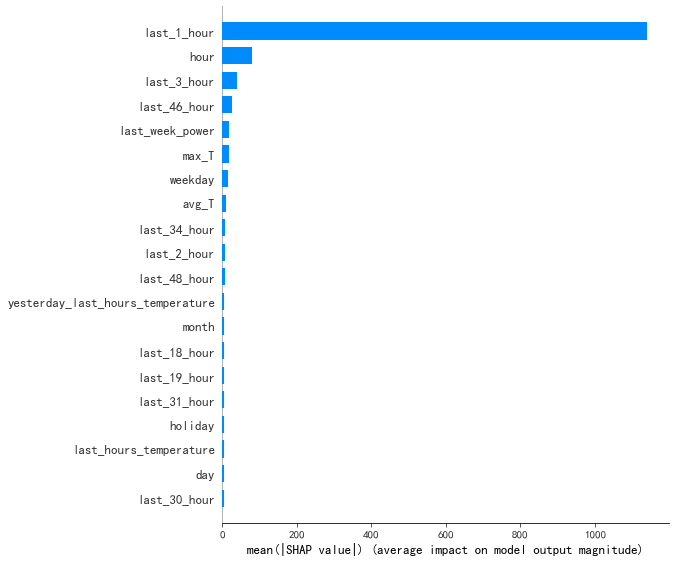

In [60]:
shap_values = explainer.shap_values(df_features_1)
shap.summary_plot(shap_values,df_features_1,plot_type="bar")

存储筛选的日负荷特征及模型

In [68]:
import joblib

In [69]:
joblib.dump(model_lgb,'./raw_data/model_lgb_1.pkl')

['./raw_data/model_lgb_1.pkl']

In [71]:
np.save('./raw_data/class_1_features.npy',importance_features)

封装训练模型过程

In [72]:
params = {
 'boosting_type': 'gbdt',
 'objective': 'regression',
 'learning_rate': 0.1,
 'n_estimators': 2500,
 'metric': 'mae',
 'num_leaves': 15,
 'max_depth': 7,
 'bagging_freq': 2,
 'bagging_fraction': 1,
 'colsample_bytree': 1,
 'min_child_samples': 18,
 'min_child_weight': 0.001,
 'reg_alpha': 0.3,
 'reg_lambda': 0.0
}

In [79]:
def train_model(df_features,params):
    df_features.reset_index(inplace=True,drop=True)
    y_train = df_features['Power']
    df_features.drop(columns=['Power'],inplace=True)
    candidate_features = df_features.columns[8:8+48].to_list()
    
    alphas = []
    for i in range(10000,210000,10000):
        alphas.append(i)
    reg = linear_model.RidgeCV(alphas=alphas)
    reg.fit(df_features[candidate_features],y_train)
    best_alpha = reg.alpha_
    
    reg = linear_model.Ridge(alpha=best_alpha)
    reg.fit(df_features[candidate_features],y_train)
    importance_features = pd.DataFrame({
            'column':candidate_features,
            'importance':np.abs(reg.coef_),
        }).sort_values(by='importance',ascending=False)
    importance_features = importance_features.iloc[:10,0].values
    
    for i in importance_features:
        candidate_features.remove(i)
    df_features.drop(columns=candidate_features,inplace=True)
    df_features.drop(columns=['year','date'],inplace=True)
    model_lgb = lgb.LGBMRegressor(**params)
    model_lgb.fit(df_features,y_train)
    
    return model_lgb,importance_features

In [82]:
model_lgb_0,importance_features_0 = train_model(df_features_0,params)

In [86]:
joblib.dump(model_lgb_0,'./raw_data/model_lgb_0.pkl')

['./raw_data/model_lgb_0.pkl']

In [87]:
np.save('./raw_data/class_0_features.npy',importance_features_0)